In [13]:
from symforce import sympy as sm
from symforce import geo
from symforce import typing as T
from symforce.opt.factor import Factor

import numpy as np
import matplotlib.pyplot as plt

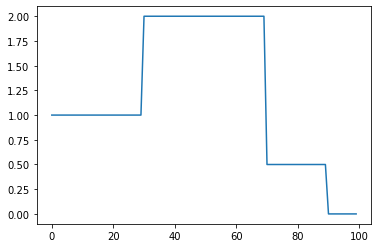

In [15]:
# build the sample speed limits

num_points = 100
interval_distance = 0.1

max_speeds = np.array([0.0 for i in range(100)])
max_speeds[0:30] = 1
max_speeds[30:70] = 2
max_speeds[70:90] = 0.5
max_speeds[90:100] = 0

max_acc = 0.1 * 9.8  # 0.1 G

plt.plot(max_speeds)

In [21]:
# build the max speed barrier factors

from symforce.opt.barrier_functions import (
    min_max_power_barrier,
    min_max_linear_barrier,
    max_linear_barrier
)


def time_function(
        speed_n: T.Scalar, speed_n_plus_1: T.Scalar, distance: T.Scalar, eps: T.Scalar
) -> T.Scalar:
    return 2.0 * distance / (speed_n + speed_n_plus_1 + eps)

def min_max_speed_residual(
        speed: T.Scalar, min_speed: T.Scalar, max_speed: T.Scalar
) -> T.Scalar:
    return min_max_linear_barrier(speed, min_speed, max_speed, 100, 0.01)

def acceleration_residual(
        speed_n: T.Scalar, speed_n_plus_1: T.Scalar, distance: T.Scalar, max_acceleration: T.Scalar, eps: T.Scalar
) -> T.Scalar:
    acc = (speed_n_plus_1 - speed_n) / time_function(speed_n, speed_n_plus_1, distance, eps)
    return max_linear_barrier(acc*acc, max_acceleration*max_acceleration, 100, 0.01)

from typing import List
def time_window_residual(speeds: List[T.Scalar], distance: T.Scalar, max_time: T.Scalar, eps:T.Scalar):
    goal_time = None
    for i in range(1, len(speeds)):
        goal_time = goal_time + time_function(speeds[i-1], speeds[i], distance, eps)
    return max_time - goal_time

In [24]:
# create factors
from symforce.opt.factor import Factor

factors = []
speed_keys = []

# add velocity constraints
for i in range(len(max_speeds)):
    factors.append(Factor(
        residual=min_max_speed_residual,
        keys=[f"speed[{i}]", f"min_speed[{i}]", f"max_speed[{i}]"],
    ))
    speed_keys.append(f"speed[{i}]")

factors.append(Factor(
    residual=time_window_residual,
    keys=[speed_keys, "distance", "max_time", "epsilon"],))

for i in range(len(max_speeds)-1):
    factors.append(Factor(
        residual=acceleration_residual,
        keys=[f"speed[{i}]", f"speed[{i+1}]", "distance", f"max_acceleration", "epsilon"],
    ))


NotImplementedError: <class 'typing._GenericAlias'> is not registered under StorageOps